<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель работы**

Спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

**Описание данных**

Набор данных находится в файле /datasets/taxi.csv.

Количество заказов находится в столбце 'num_orders' 

**План работы**

- Изучить данные, выявить пропущенные значения
- Провести предобработку и анализ данных
- Разделить выборку на тренировочную и тестовую
- Выбрать для каждой из четырех моделей лучшие параметры
- Обучить четыре модели с выбранными параметрами и сравнить их по качеству
- Лучшую модель проверить на тестовой выборке
- Написать вывод

## Подготовка

In [1]:
!pip install scikit-learn==1.1.3

In [2]:
# загрузка необходимых библиотек
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [3]:
# загрузка данных 
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [4]:
# проверим монотонность индекса
print(data.index.is_monotonic)

True


In [5]:
# первые пять сторок и последние пять строк
display(data.head())
display(data.tail())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [6]:
# информация о данных 
data.info()
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


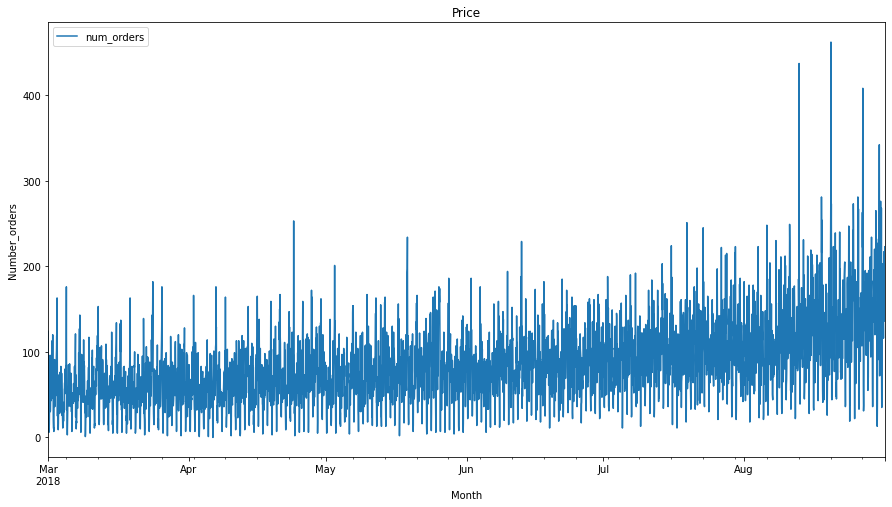

In [7]:
# ресемплирование по одному часу
data = data.resample('1H').sum()
figsize = (15,8)
data.plot(figsize=figsize)
plt.xlabel('Month')
plt.ylabel('Number_orders')
plt.title('Price')
plt.show()

**Вывод по пункту 1**

В ходе изучения данных было получено следующее:
- данные состоят из 26496 сторок и одного столбца с количеством заказов
- временной промежуток составляет полгода
- пропусков нет
- в основном, количество заказов находится в промежутке от 0 до 100
- после разбиения по одному часу мы получили нестационарный временной ряд, значения которого к августу увеличились, есть единичные выбросы

## Анализ

Разложим временной ряд на тренд, сезонность и остатки

In [8]:
decomposed = seasonal_decompose(data)

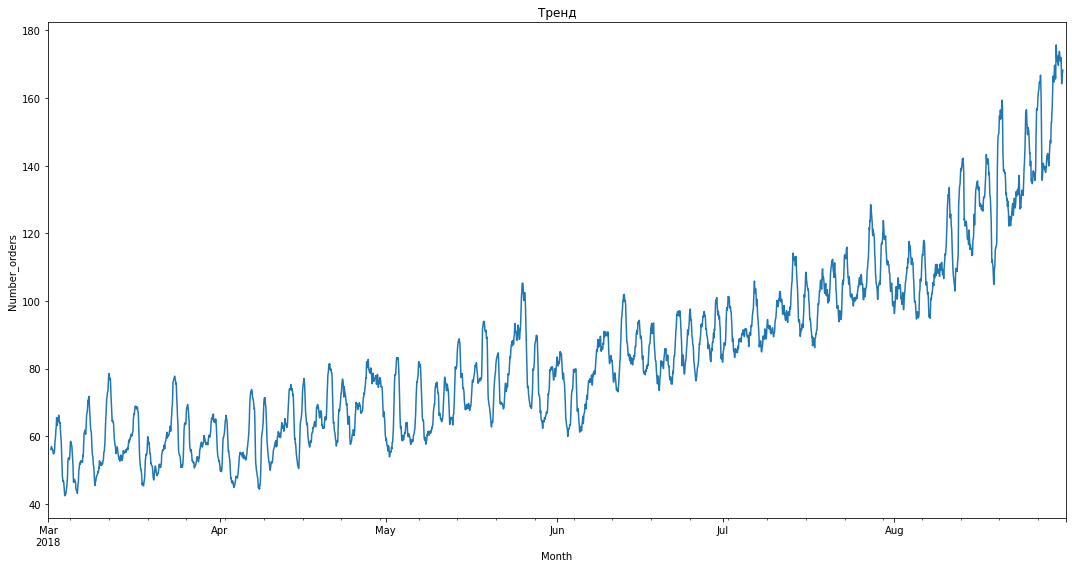

In [9]:
# построение графика тренда
decomposed.trend.plot(ax=plt.gca(), figsize=(15,8))
plt.xlabel('Month')
plt.ylabel('Number_orders')
plt.title('Тренд')
plt.tight_layout()
plt.show()

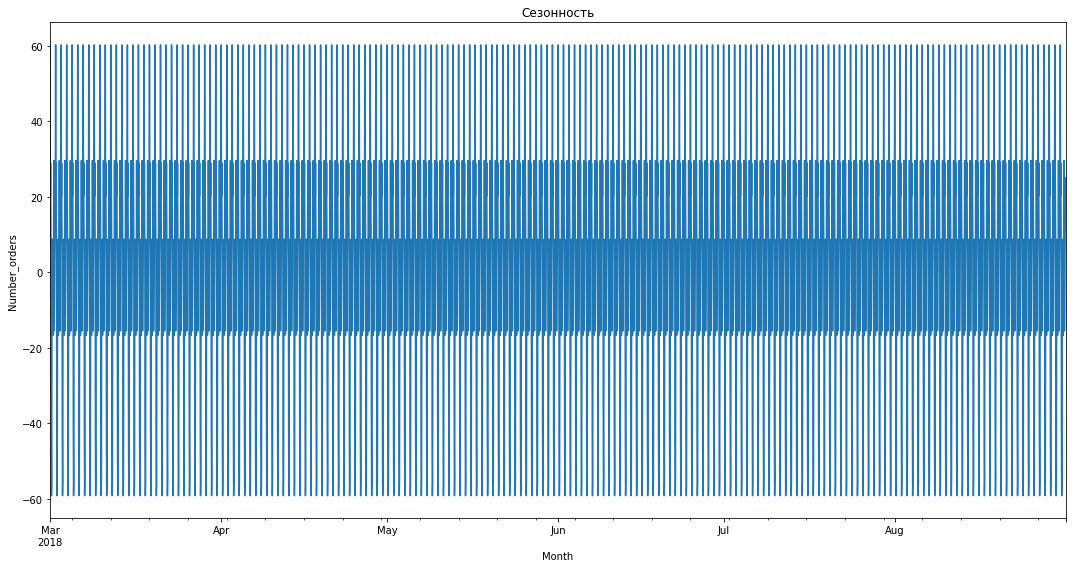

In [10]:
# построение графика сезонности
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15,8))
plt.xlabel('Month')
plt.ylabel('Number_orders')
plt.title('Сезонность')
plt.tight_layout()
plt.show()

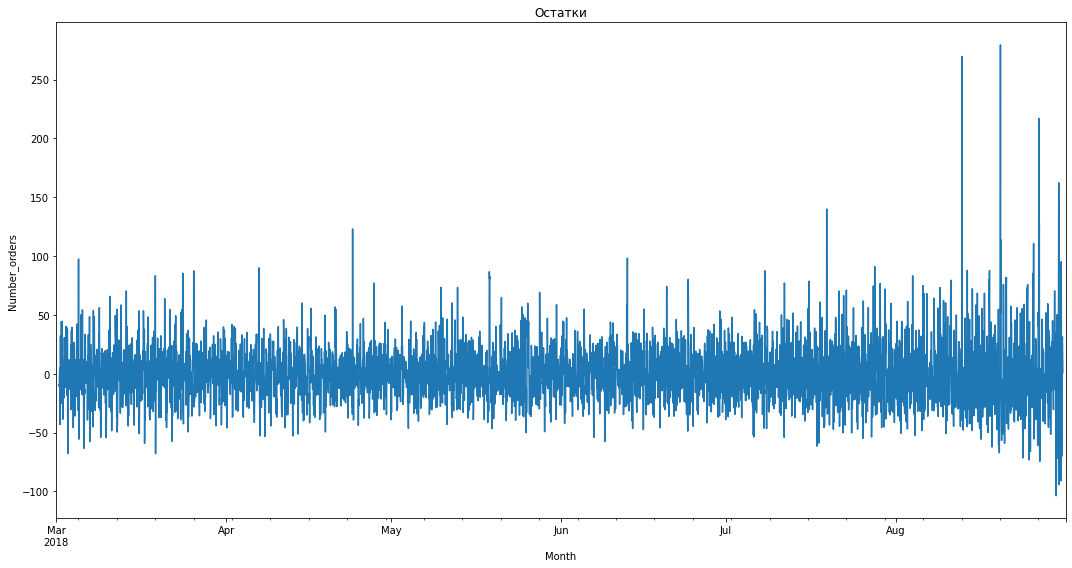

In [11]:
# построение графика остатков
decomposed.resid.plot(ax=plt.gca(), figsize=(15,8))
plt.xlabel('Month')
plt.ylabel('Number_orders')
plt.title('Остатки')
plt.tight_layout()
plt.show()

По графику тренда видно, что со временем происходит рост количества заказов, особенно к сентябрю. Заметна сезонность, но чтобы лучше ее понять, необходимо рассмотреть на меньшем промежутке времени. Рассмотрим какую-нибудь неделю

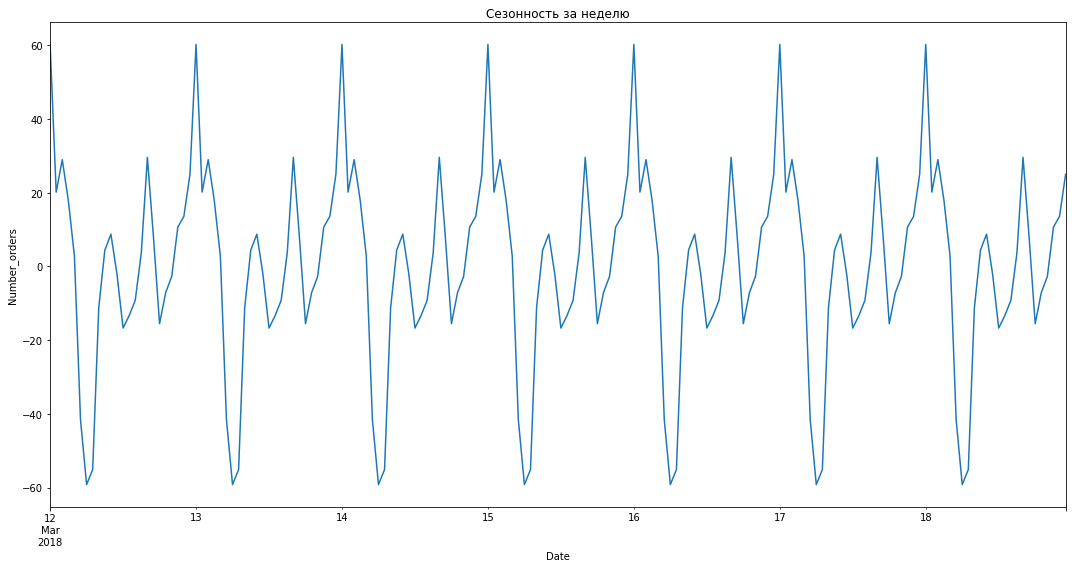

In [12]:
decomposed = decomposed.seasonal['2018-03-12':'2018-03-18']
decomposed.plot(ax=plt.gca(), figsize=(15,8))
plt.xlabel('Date')
plt.ylabel('Number_orders')
plt.title('Сезонность за неделю')
plt.tight_layout()
plt.show()

По графику за неделю мы видим,что каждый день пик заказов приходится на ночное время, затем спад и потом рост заказов во второй половине дня.

**Вывод по пункту 2**

В ходе анализа данных было выполнено и получено следующее:
- произведено разделение временного ряда на тренд, сезонность и остатки
- по графику тренда был замечен рост заказов к концу рассматриваемого периода
- по графику сезонности был замечен ежедневный пик заказов в ночное время, затем спад и потом рост заказов во второй половине дня.

## Обучение

**3.1 Подготовка признаков**

Создадим новые признаки для обучения моделей: 
- календарные(час, день и день недели)
- отстающие значения
- скользящее среднее

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean().shift()
    

In [14]:
make_features(data, 4, 24)

In [15]:
display(data.head(10))
print(data.shape)

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,5,1,3,43.0,66.0,71.0,85.0,NaN
2018-03-01 06:00:00,12,6,1,3,6.0,43.0,66.0,71.0,NaN
2018-03-01 07:00:00,15,7,1,3,12.0,6.0,43.0,66.0,NaN
2018-03-01 08:00:00,34,8,1,3,15.0,12.0,6.0,43.0,NaN


(4416, 9)


Разобьем данные на тренировочную и тестовую выборки. Для временных рядов перемешивать данные нельзя. 

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

Отделим целевой признак от остальных

In [17]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print(features_train.shape)
print(target_train.shape)

print(features_test.shape)
print(target_test.shape)

(3950, 8)
(3950,)
(442, 8)
(442,)


Данные готовы к работе

**3.2 Обучение моделей и подбор параметров**

**LinearRegression**

In [18]:
splits = TimeSeriesSplit(n_splits=5)
model_linear= LinearRegression()
cross_score_linear = (cross_val_score(model_linear, features_train, target_train, cv=splits, scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE LinearRegression =', cross_score_linear)

Mean RMSE LinearRegression = 31.984317891506883


**DecisionTreeRegressor**

In [19]:
model_tree = DecisionTreeRegressor()
max_depth_list = [x for x in range(1, 31)]
hyperparams = [{'criterion':['squared_error'], 'max_depth':max_depth_list, 'random_state':[12345]}]
score_tree = GridSearchCV(model_tree, hyperparams, scoring='neg_mean_squared_error', cv=splits)
score_tree.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(score_tree.best_params_)
print()
print("Grid scores on development set:")
print()
means = score_tree.cv_results_['mean_test_score']
for mean, params in zip(means, score_tree.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
cv_RMSE_tree = (max(means)*-1) ** 0.5
print()
print('Best RMSE DecisionTreeRegressor =', cv_RMSE_tree)

Best parameters set found on development set:

{'criterion': 'squared_error', 'max_depth': 8, 'random_state': 12345}

Grid scores on development set:

36.974653 for {'criterion': 'squared_error', 'max_depth': 1, 'random_state': 12345}
34.819055 for {'criterion': 'squared_error', 'max_depth': 2, 'random_state': 12345}
32.587885 for {'criterion': 'squared_error', 'max_depth': 3, 'random_state': 12345}
31.762378 for {'criterion': 'squared_error', 'max_depth': 4, 'random_state': 12345}
30.240672 for {'criterion': 'squared_error', 'max_depth': 5, 'random_state': 12345}
29.437483 for {'criterion': 'squared_error', 'max_depth': 6, 'random_state': 12345}
29.718647 for {'criterion': 'squared_error', 'max_depth': 7, 'random_state': 12345}
29.357581 for {'criterion': 'squared_error', 'max_depth': 8, 'random_state': 12345}
31.503790 for {'criterion': 'squared_error', 'max_depth': 9, 'random_state': 12345}
30.491613 for {'criterion': 'squared_error', 'max_depth': 10, 'random_state': 12345}
31.24434

Лучшее RMSE показала модель с глубиной 8

**CatBoostRegressor**

In [20]:
model_catboost = CatBoostRegressor()
hyperparams = [{'depth':[3, 6, 9], 'learning_rate':[0.1, 0.3, 0.5, 0.7, 0.9], 'random_state':[12345], 'verbose':[False]}]
score_catboost = GridSearchCV(model_catboost, hyperparams, scoring='neg_mean_squared_error', cv=splits)
score_catboost.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(score_catboost.best_params_)
print()
print("Grid scores on development set:")
print()
means = score_catboost.cv_results_['mean_test_score']
for mean, params in zip(means, score_catboost.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
    print()
cv_RMSE_catboost = (max(means)*-1) ** 0.5
print()
print('Best RMSE CatBoostRegressor =', cv_RMSE_catboost)

Best parameters set found on development set:

{'depth': 3, 'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}

Grid scores on development set:

26.488208 for {'depth': 3, 'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}

28.241707 for {'depth': 3, 'learning_rate': 0.3, 'random_state': 12345, 'verbose': False}

29.298822 for {'depth': 3, 'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

30.273929 for {'depth': 3, 'learning_rate': 0.7, 'random_state': 12345, 'verbose': False}

32.160195 for {'depth': 3, 'learning_rate': 0.9, 'random_state': 12345, 'verbose': False}

26.841612 for {'depth': 6, 'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}

27.634822 for {'depth': 6, 'learning_rate': 0.3, 'random_state': 12345, 'verbose': False}

28.773552 for {'depth': 6, 'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

29.515828 for {'depth': 6, 'learning_rate': 0.7, 'random_state': 12345, 'verbose': False}

30.959432 for {'depth': 

Лучшее RMSE показала модель с параметром learning_rate=0.1 и depth=3

**LGBMRegressor**

In [21]:
model_lgbm = LGBMRegressor()
hyperparams = [{'num_leaves':[31, 100, 200], 'learning_rate':[0.1, 0.4, 0.7], 'random_state':[12345]}]
score_lgbm = GridSearchCV(model_lgbm, hyperparams, scoring='neg_mean_squared_error', cv=splits)
score_lgbm.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(score_lgbm.best_params_)
print()
print("Grid scores on development set:")
print()
means = score_lgbm.cv_results_['mean_test_score']
for mean, params in zip(means, score_lgbm.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()
cv_RMSE_lgbm = (max(means)*-1) ** 0.5
print()
print('Best RMSE LGBMRegressor =', cv_RMSE_lgbm)

Best parameters set found on development set:

{'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}

Grid scores on development set:

25.903436 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}
26.260500 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}
26.317542 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}
28.071990 for {'learning_rate': 0.4, 'num_leaves': 31, 'random_state': 12345}
27.991190 for {'learning_rate': 0.4, 'num_leaves': 100, 'random_state': 12345}
27.892991 for {'learning_rate': 0.4, 'num_leaves': 200, 'random_state': 12345}
29.552420 for {'learning_rate': 0.7, 'num_leaves': 31, 'random_state': 12345}
29.265742 for {'learning_rate': 0.7, 'num_leaves': 100, 'random_state': 12345}
29.213769 for {'learning_rate': 0.7, 'num_leaves': 200, 'random_state': 12345}


Best RMSE LGBMRegressor = 25.903436477736253


Лучшее RMSE показала модель с параметрами learning_rate=0.1 и num_leaves=31

**3.3 Выбор лучшей модели по RMSE** 

**Сводная таблица результатов**

In [22]:
index = ['LinearRegression','DecisionTreeRegressor', 'CatBoostRegressor', 'LGBMRegressor']
data = {'RMSE':[cross_score_linear, cv_RMSE_tree, cv_RMSE_catboost, cv_RMSE_lgbm]}
        
data_score = pd.DataFrame(data=data, index=index)
data_score['Рейтинг RMSE'] = (data_score['RMSE'].min() / data_score['RMSE'])

data_score

,RMSE,Рейтинг RMSE
LinearRegression,31.984318,0.809879
DecisionTreeRegressor,29.357581,0.882342
CatBoostRegressor,26.488208,0.977923
LGBMRegressor,25.903436,1.000000


**Вывод по пункту 3**

В ходе выполнения данного пункта было сделано и получено следующее:
- Созданы новые признаки для обучения моделей: 
    - календарные(час, день и день недели)
    - отстающие значения
    - скользящее среднее
- Разбили данные на тренировочную и тестовую выборки. 
- Отделили целевой признак от остальных
- У четырех выбранных моделей подобрали по RMSE лучшие параметры
- Результаты свели в таблицу

Самую лучшую точность показала модель LGBMRegressor, ее и будем тестировать	

## Тестирование

In [23]:
%%time

# проверка финальной модели на тестовой выборке

predict_lgbm = score_lgbm.predict(features_test)

CPU times: user 120 ms, sys: 6 µs, total: 120 ms
Wall time: 60.5 ms


In [24]:
RMSE_lgbm = mean_squared_error(target_test, predict_lgbm) ** 0.5

print('RMSE LGBMRegressor =', RMSE_lgbm)

RMSE LGBMRegressor = 45.61428181294412


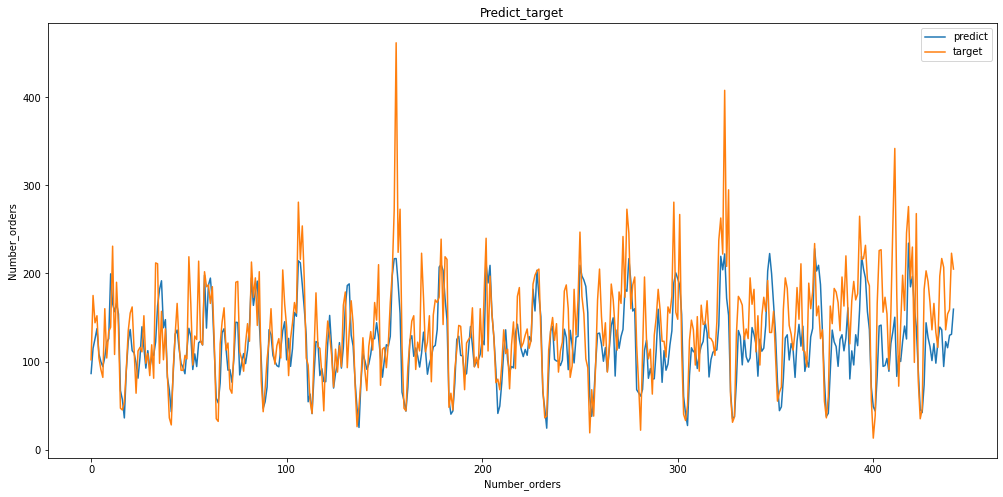

In [25]:
a = predict_lgbm.tolist()
b = target_test.tolist()
plt.figure(figsize=(17, 8))
plt.plot(a, label = "predict")
plt.plot(b, label = "target")
plt.legend()
plt.xlabel('Number_orders')
plt.ylabel('Number_orders')
plt.title('Predict_target')
plt.show()

На тестовой выборке финальная модель показала себя также хорошо

**Общий вывод**

В ходе изучения данных было получено следующее:
- данные состоят из 26496 сторок и одного столбца с количеством заказов
- временной промежуток составляет полгода
- пропусков нет
- в основном, количество заказов находится в промежутке от 0 до 100
- после разбиения по одному часу мы получили почти стационарный временной ряд, значения которого к августу увеличились, есть единичные выбросы

В ходе анализа данных было выполнено и получено следующее:
- произведено разделение временного ряда на тренд, сезонность и остатки
- по графику тренда был замечен рост заказов к концу рассматриваемого периода
- по графику сезонности был замечен ежедневный пик заказов в ночное время, затем спад и потом рост заказов во второй половине дня.

В ходе выполнения пункта 3 было сделано и получено следующее:
- Созданы новые признаки для обучения моделей: 
    - календарные(час, день и день недели)
    - отстающие значения
    - скользящее среднее
- Разбили данные на тренировочную и тестовую выборки. 
- Отделили целевой признак от остальных
- У четырех выбранных моделей подобрали по RMSE лучшие параметры
- Результаты свели в таблицу

Самую лучшую точность и неплохое время показала модель LGBMRegressor, ее и выбрали для тестирования


На тестовой выборке финальная модель также показала хорошую точность